### Extacting every 10th frame 

In [13]:
# import cv2
# import os

# # Paths
# video_path = "D:/UOB/Dessertation/Image dataset/MJF_XY_s4.avi"
# output_dir = "D:/UOB/Dessertation/Image dataset/frames2/S4"
# frame_interval = 10

# # Create output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)

# # Read video
# cap = cv2.VideoCapture(video_path)
# frame_idx = 0
# saved_count = 0

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     if frame_idx % frame_interval == 0:
#         #to grayscale
#         frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         filename = os.path.join(output_dir, f"s4_{frame_idx:04d}.png")
#         cv2.imwrite(filename, frame_gray)
#         saved_count += 1

#     frame_idx += 1

# cap.release()
# print(f"Saved {saved_count} frames every 10th frame into output folder.")


### Etracting the masked images

In [14]:
# import cv2
# import numpy as np
# import os
# import json
# import matplotlib.pyplot as plt
# from glob import glob

# # Input images (uploaded fracture images)
# input_dir = "D:/UOB/Dessertation/Image dataset/frames2/S2"
# image_paths = sorted(glob(os.path.join(input_dir, "*.png")))

# # Output folders
# mask_dir = "D:/UOB/Dessertation/Image dataset/Labeled_crack_mask"
# os.makedirs(mask_dir, exist_ok=True)

# tip_coords = {}

# # Simple synthetic mask creation for demonstration (based on thresholding the crack line area)
# for path in image_paths:
#     filename = os.path.basename(path)
#     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

#     # Enhance contrast and apply threshold
#     blur = cv2.GaussianBlur(img, (5, 5), 0)
#     _, mask = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY_INV)

#     # Keep only narrow features 
#     kernel = np.ones((3, 3), np.uint8)
#     thin_mask = cv2.erode(mask, kernel, iterations=2)
#     thin_mask = cv2.dilate(thin_mask, kernel, iterations=2)

#     # Save mask
#     mask_filename = os.path.join(mask_dir, filename)
#     cv2.imwrite(mask_filename, thin_mask)

#     # Estimate crack tip
#     ys, xs = np.where(thin_mask > 0)
#     if len(xs) > 0:
#         tip_x, tip_y = int(np.max(xs)), int(ys[np.argmax(xs)])
#         tip_coords[filename] = {"x": tip_x, "y": tip_y}

# # Save 
# tip_json_path = "/mnt/data/crack_tip_coordinates.json"
# with open(tip_json_path, "w") as f:
#     json.dump(tip_coords, f, indent=4)



### U-Net training

In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
import torch.nn as nn

print(f"Using device: {device}")


Using device: cuda


In [3]:

class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted([
            f for f in os.listdir(image_dir)
            if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f.replace(".png", "_mask.png")))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        mask_name = image_name.replace(".png", "_mask.png")

        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to read image: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to read mask: {mask_path}")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Add channel dim to mask
        return image, mask.unsqueeze(0).float() / 255.0


In [4]:
#augmentation and dataloading
train_transform = A.Compose([
    A.LongestMaxSize(max_size=512),       
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = CrackDataset(
    image_dir="D:/UOB/Dessertation/Image dataset/Datasets/Data/Rawimages",
    mask_dir="D:/UOB/Dessertation/Image dataset/Datasets/Data/Binarymasked",
    transform=train_transform
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


In [5]:
#u-net model with pretrained encoder
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)


In [6]:
#define loss function and optimizer
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Dice score function
def dice_score(preds, targets, threshold=0.5):
    preds = (sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return (2. * intersection + 1e-8) / (union + 1e-8)

In [7]:
from torch import sigmoid
# Training loop
num_epochs = 60
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    total_dice = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)

        loss = dice_loss(preds, masks) + bce_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Dice score tracking
        total_dice += dice_score(preds, masks).item()

    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Avg Dice: {avg_dice:.4f}")

Epoch 1/60, Avg Loss: 1.6864, Avg Dice: 0.0064
Epoch 2/60, Avg Loss: 1.4874, Avg Dice: 0.0243
Epoch 3/60, Avg Loss: 1.3983, Avg Dice: 0.0480
Epoch 4/60, Avg Loss: 1.3447, Avg Dice: 0.0749
Epoch 5/60, Avg Loss: 1.3078, Avg Dice: 0.0936
Epoch 6/60, Avg Loss: 1.2801, Avg Dice: 0.1241
Epoch 7/60, Avg Loss: 1.2558, Avg Dice: 0.1333
Epoch 8/60, Avg Loss: 1.2383, Avg Dice: 0.1513
Epoch 9/60, Avg Loss: 1.2199, Avg Dice: 0.1546
Epoch 10/60, Avg Loss: 1.2028, Avg Dice: 0.1712
Epoch 11/60, Avg Loss: 1.1887, Avg Dice: 0.2004
Epoch 12/60, Avg Loss: 1.1742, Avg Dice: 0.2368
Epoch 13/60, Avg Loss: 1.1623, Avg Dice: 0.2508
Epoch 14/60, Avg Loss: 1.1502, Avg Dice: 0.3188
Epoch 15/60, Avg Loss: 1.1399, Avg Dice: 0.3310
Epoch 16/60, Avg Loss: 1.1298, Avg Dice: 0.3721
Epoch 17/60, Avg Loss: 1.1209, Avg Dice: 0.3682
Epoch 18/60, Avg Loss: 1.1124, Avg Dice: 0.3975
Epoch 19/60, Avg Loss: 1.1052, Avg Dice: 0.4051
Epoch 20/60, Avg Loss: 1.0988, Avg Dice: 0.3733
Epoch 21/60, Avg Loss: 1.0893, Avg Dice: 0.3999
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


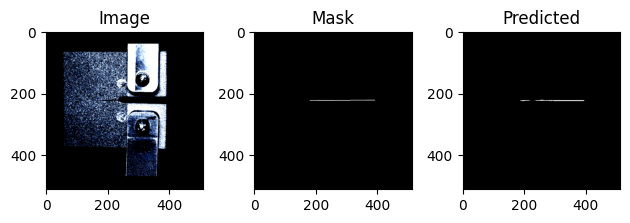

In [8]:
#model evaluation
model.save_pretrained("crack_segmentation_model_0.70.pth")
torch.save(model.state_dict(), "crack_segmentation_model_weights_0.70.pth")
model.eval()
with torch.no_grad():
    img, msk = train_dataset[0]
    pred = model(img.unsqueeze(0).to(device))[0, 0].cpu().numpy()
    plt.subplot(1, 3, 1); plt.imshow(img.permute(1, 2, 0)); plt.title("Image")
    plt.subplot(1, 3, 2); plt.imshow(msk[0], cmap='gray'); plt.title("Mask")
    plt.subplot(1, 3, 3); plt.imshow(pred > 0.5, cmap='gray'); plt.title("Predicted")
    plt.tight_layout(); plt.show()


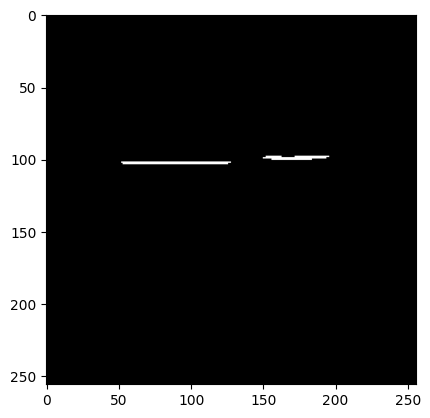

In [9]:
#testing model with random image
img = cv2.imread(r"D:\UOB\Dessertation\Image dataset\frames2\S1\s1_0700.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
aug = A.Normalize()(image=img)["image"]
tensor = ToTensorV2()(image=aug)["image"].unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(tensor)[0, 0].cpu().numpy()

plt.imshow(pred > 0.5, cmap='gray')

## Crack Mask Overlay for Tip Segmentation



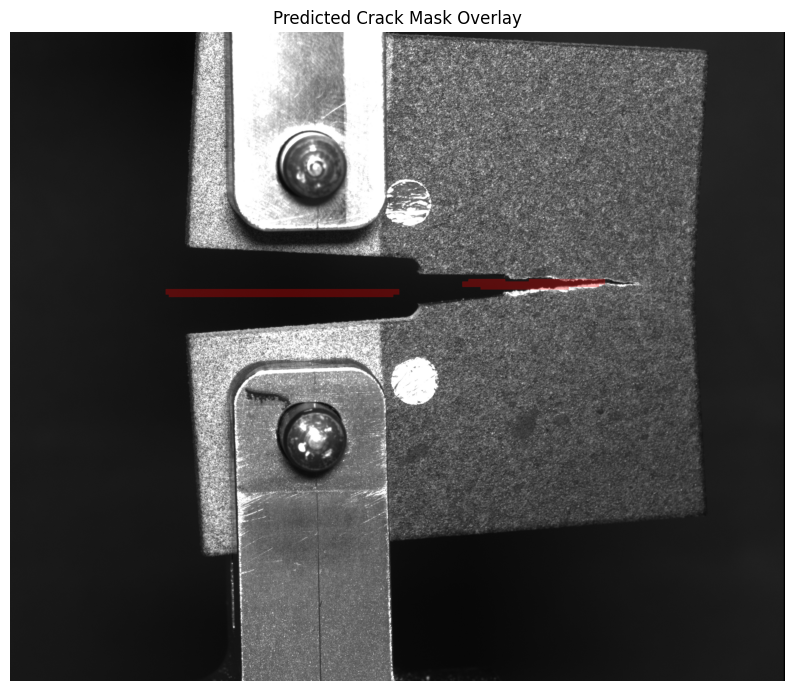

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch

# Load and preprocess image
img_path = r"D:\UOB\Dessertation\Image dataset\frames2\S1\s1_0700.png"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (256, 256))

# Normalize and convert to tensor
aug = A.Normalize()(image=img_resized)["image"]
tensor = ToTensorV2()(image=aug)["image"].unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    pred = model(tensor)[0, 0].cpu().numpy()

# Threshold prediction
pred_mask = (pred > 0.5).astype(np.uint8) * 255

# Resize mask back to original image size
pred_mask_resized = cv2.resize(pred_mask, (img.shape[1], img.shape[0]))

# Create red overlay on the original image
kernel = np.ones((3, 3), np.uint8)
pred_mask_resized = cv2.dilate(pred_mask_resized, kernel, iterations=1)
overlay = img_rgb.copy()
overlay[pred_mask_resized > 0] = [255, 0, 0]  # Red in RGB

# Blend with original image
blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title("Predicted Crack Mask Overlay")
plt.axis("off")
plt.show()


## crack mask overlay with binary image


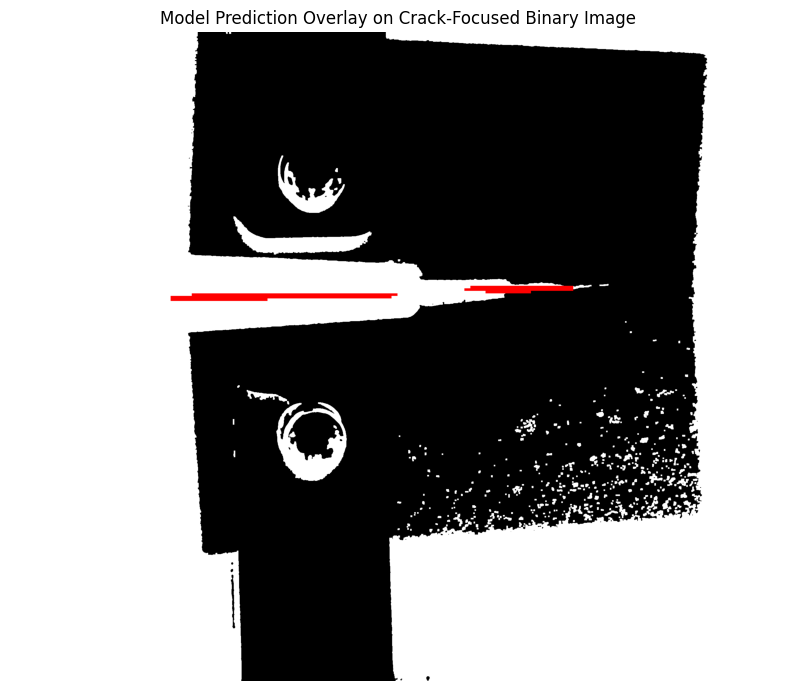

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch


img_path = r"D:\UOB\Dessertation\Image dataset\frames2\S1\s1_0600.png"
raw = cv2.imread(img_path)
gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)

#crack-focused binary image (from your old script)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY_INV)

# Narrow crack mask to remove noise
kernel = np.ones((3, 3), np.uint8)
binary_thin = cv2.erode(binary, kernel, iterations=2)
binary_thin = cv2.dilate(binary_thin, kernel, iterations=2)

# Convert to RGB for overlay
binary_rgb = cv2.cvtColor(binary_thin, cv2.COLOR_GRAY2RGB)

#prepare model input
img_resized = cv2.resize(raw, (256, 256))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
aug = A.Normalize()(image=img_rgb)["image"]
tensor = ToTensorV2()(image=aug)["image"].unsqueeze(0).to(device)

#Predict
model.eval()
with torch.no_grad():
    pred = model(tensor)[0, 0].cpu().numpy()

#Postprocess prediction
pred_mask = (pred > 0.5).astype(np.uint8) * 255
pred_mask_resized = cv2.resize(pred_mask, (raw.shape[1], raw.shape[0]), interpolation=cv2.INTER_NEAREST)

#Overlay on binary background
blended = binary_rgb.copy()
blended[pred_mask_resized > 0] = [255, 0, 0]  # Strong red with no transparency


plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title("Model Prediction Overlay on Crack-Focused Binary Image")
plt.axis("off")
plt.show()


### Crack tip segmentation

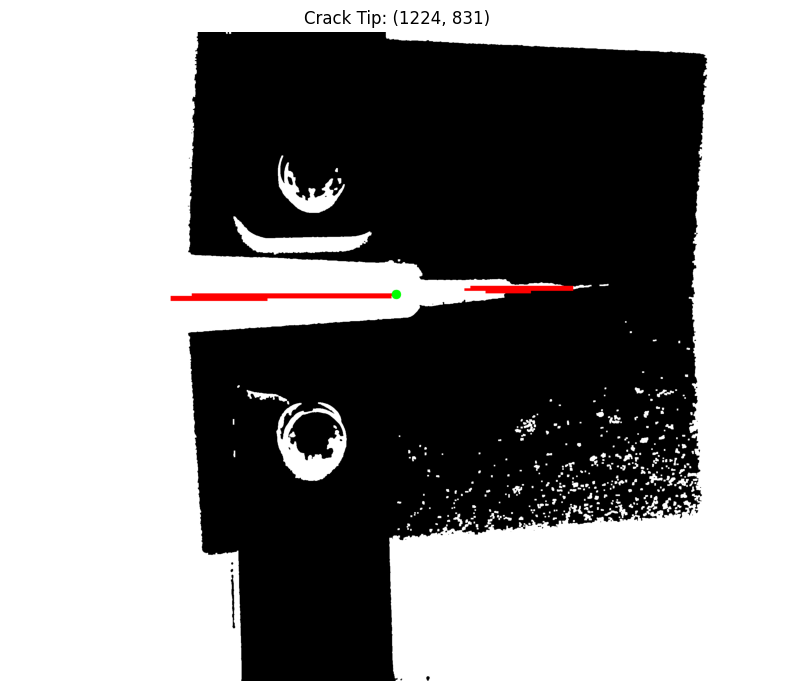

In [12]:
from skimage.morphology import skeletonize
from skimage.measure import label

def extract_crack_tip_from_array(overlay_img):
    """
    Accepts a NumPy array of the overlay image.
    Returns the (x, y) crack tip coordinates and the annotated image.
    """
    # Extract red regions (where the predicted mask was drawn)
    red_channel = overlay_img[:, :, 0]  # since image is RGB now
    green_channel = overlay_img[:, :, 1]
    blue_channel = overlay_img[:, :, 2]

    # Identify red pixels as crack
    crack_mask = ((red_channel > 150) & (green_channel < 100) & (blue_channel < 100)).astype(np.uint8)

    # Keep largest connected component
    def get_largest_component(mask):
        labeled = label(mask)
        if labeled.max() == 0:
            return np.zeros_like(mask)
        largest = (labeled == (np.argmax(np.bincount(labeled.flat)[1:]) + 1)).astype(np.uint8)
        return largest

    clean_mask = get_largest_component(crack_mask)

    # Skeletonize the cleaned crack mask
    skeleton = skeletonize(clean_mask)

    # Detect endpoints in skeleton
    def find_endpoints(skel):
        skel_uint8 = skel.astype(np.uint8)
        kernel = np.array([[1,1,1],
                           [1,10,1],
                           [1,1,1]], dtype=np.uint8)
        filtered = cv2.filter2D(skel_uint8, -1, kernel)
        tips = np.argwhere(filtered == 11)
        return tips

    tips = find_endpoints(skeleton)

    if len(tips) > 0:
        # Rightmost point (assuming crack grows left to right)
        tip_coord = sorted(tips, key=lambda p: p[1], reverse=True)[0]
        tip_x, tip_y = int(tip_coord[1]), int(tip_coord[0])
    else:
        tip_x, tip_y = None, None

    # Draw tip on a copy of the image
    annotated = overlay_img.copy()
    if tip_x is not None:
        cv2.circle(annotated, (tip_x, tip_y), 15, (0, 255, 0), -1)

    return annotated, (tip_x, tip_y)

# Run it on the blended image from your previous cell
result_img, crack_tip = extract_crack_tip_from_array(blended)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(result_img)
plt.title(f"Crack Tip: {crack_tip}" if crack_tip else "Crack Tip Not Found")
plt.axis("off")
plt.show()
